Программа получает на вход файлы из папки, в которых содержатся данные для построения графиков, отрисовывает каждый график и по надобности сохраняет его. Дополнительно увеличение по временному масштабу 100 нс, 1 мкс, 10 мкс.  
_______
**Названия рисунков**  
AAA.A_CCC_D_E.png 
AAA.A – Толщина образца и порядковый номер (400.1)   
CCC – Номер эксперимента (001)  
D – Количество импульсов(1)  
E – Энергия в импульсе нДж (5)  
____
**Пример** получившегося названия:  
400.1.060924.001.1.5.png

#### Задачи:
- Название файлов
- Перевод в Вт
- Обрабатывать новые файлы в режиме реального времени
- Inf/Nan - исправить

In [ ]:
!pip install pandas matplotlib openpyxl scipy watchdog

450.2_80_4_12.95
Tek080_ALL.csv


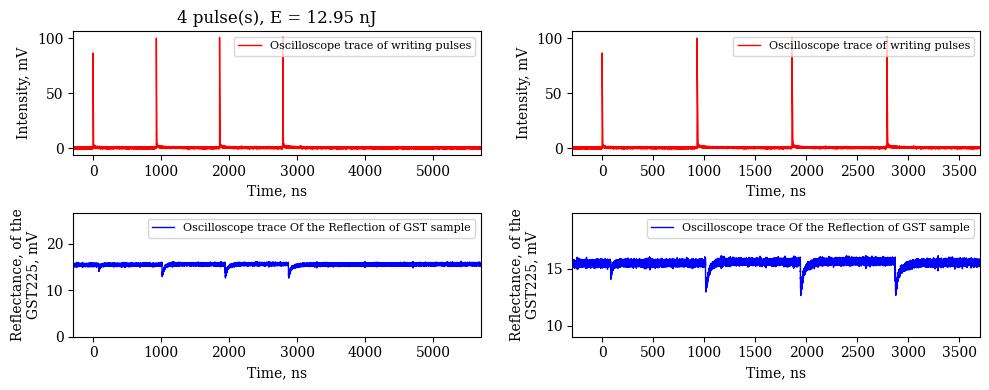

450.2_90_5_6.01
Tek090_ALL.csv


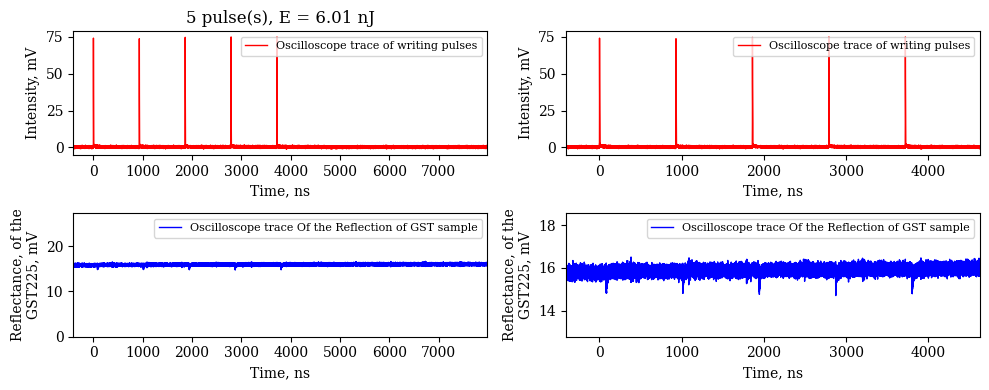

450.2_109_4_16.4
Tek109_ALL.csv


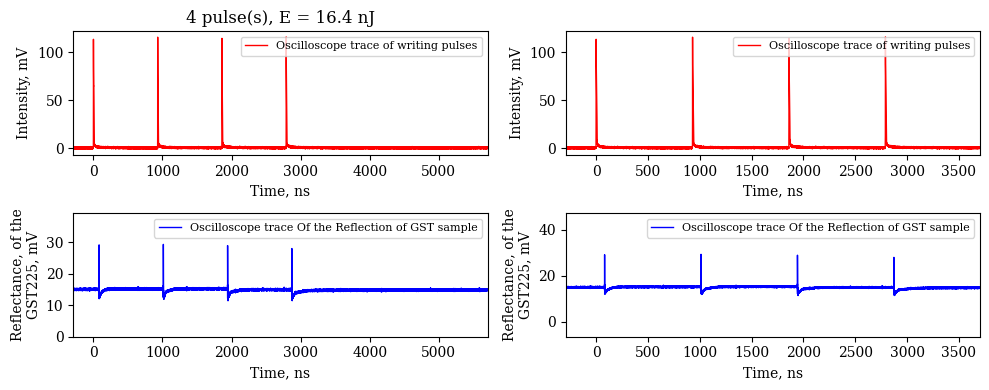

450.2_117_1_19.36
Tek117_ALL.csv


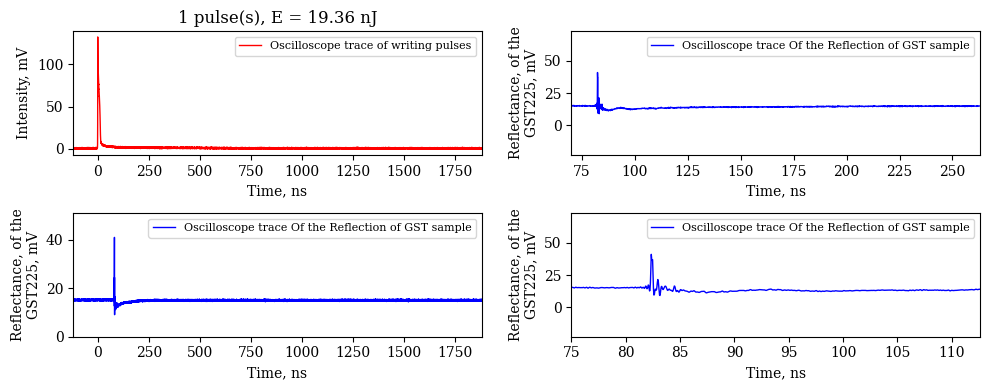

450.2_123_1_20.08
Tek123_ALL.csv


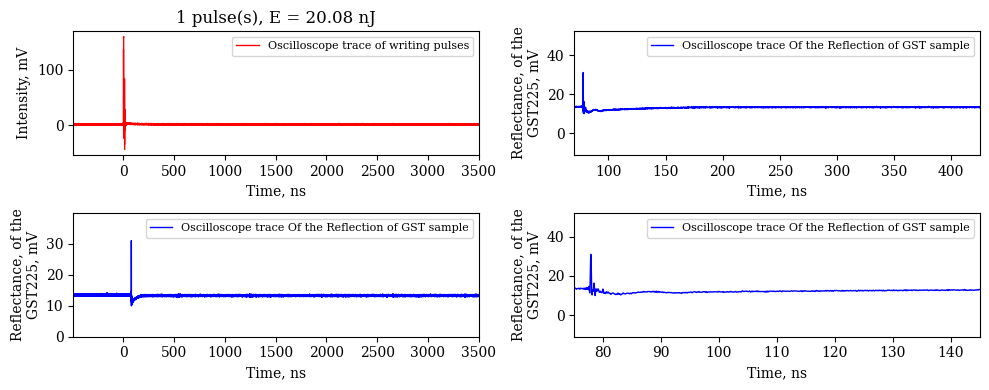

New file created: waveforms/test/Tek126_ALL.csv
450.2_126_1_6.01
Tek126_ALL.csv


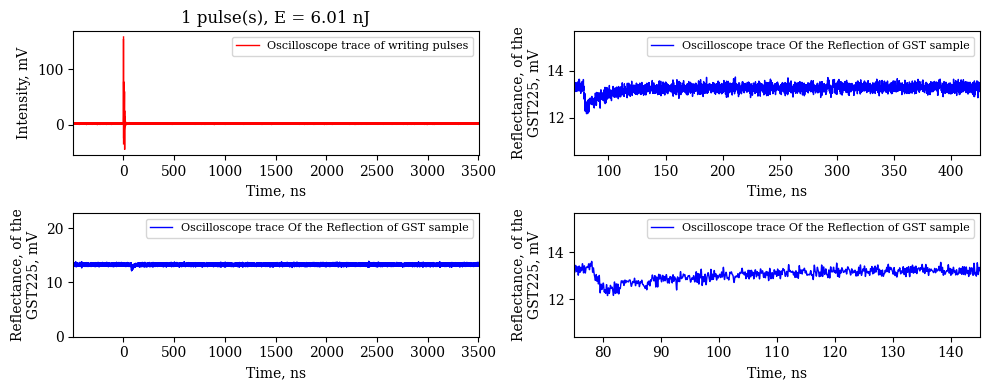

File 450.2_126_1_6.01.png is saved in results/450.2/
File 450.2_126_1_6.01.csv is saved




In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

# ПАРАМЕТРЫ
sample = '450.2'    # маркер образца

start_file = None   # Если в папке с осциллограммами уже есть файлы и нужно обработать не все, 
                    # УКАЗАТЬ с кого начать (перед ним все проспускаются)
# start_file = 'Tek117_ALL.csv' # Rigol
# start_file = 'Tek012.csv' # Tektronix

dir = 'waveforms/test/'     # папка с осциллограммами
# dir = 'waveforms/110924/' 
# dir = 'waveforms/060924/Осциллограммы переходов/'
general_file = 'waveforms/parameters/' + sample + '.xlsx'   # папка с параметрами образцов
save_dir = 'results/' + sample + '/'    # папка для результатов каждого из образцов


############################################################ Тут все функции
def create_dir():
    try:
        os.makedirs(save_dir)
    except FileExistsError:
        # directory already exists
        pass

def plot_graph(df, x, y, color_, label_, ylabel, xlabel, xlim1, xlim2, increase, x2_supplement):
    plt.xlim(xlim1, xlim2/increase + x2_supplement)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel(xlabel, fontsize=10)
    plt.plot(df[x]*1e9, df[y]*1e3, color=color_, linewidth=1,
             label=label_)
    plt.legend(fontsize=8)


def plot_graphics(df, pulses, energy, flag_pulse, peak, x2_supplement, y_start, y_end, y_avg, y_max):
    plt.figure(figsize=(10, 4))
    plt.rcParams["font.family"] = "serif" # font

    # 1) Без увеличения
    plt.subplot(2, 2, 1)
    plot_graph(df, x='TIME', y='CH1', color_='red', 
        label_='Oscilloscope trace of writing pulses', 
        ylabel='Intensity, mV', xlabel='Time, ns', 
        xlim1=df.iloc[0, 0]*1e9, xlim2=df.iloc[-1, 0]*1e9, increase=1, x2_supplement=0)
    plt.title(label= f'{pulses} pulse(s), E = {energy} nJ')


    plt.subplot(2, 2, 3)
    plot_graph(df, x='TIME', y='CH2', color_='blue', 
        label_='Oscilloscope trace Of the Reflection of GST sample', 
        ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
        xlim1=df.iloc[0, 0]*1e9, xlim2=df.iloc[-1, 0]*1e9, increase=1, x2_supplement=0)
    plt.ylim(0, (y_max + y_avg*2/3 )*1e3)
    

    # 2) Увеличение
    plt.subplot(2, 2, 2)
    if (flag_pulse=='one'):
        plot_graph(df, x='TIME', y='CH2', color_='blue', 
            label_='Oscilloscope trace Of the Reflection of GST sample', 
            ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
            xlim1=70, xlim2=(df.iloc[-1, 0]*1e9), increase=10, x2_supplement=x2_supplement)
        plt.ylim(y_start*1e3, y_end*1e3)
        
    else:
        plot_graph(df, x='TIME', y='CH1', color_='red', 
            label_='Oscilloscope trace of writing pulses', 
            ylabel='Intensity, mV', xlabel='Time, ns', 
            xlim1=df.iloc[0, 0]*1e9, xlim2=df.iloc[peak, 0]*1e9+926, increase=1, x2_supplement=0)


    # 3) Увеливение
    plt.subplot(2, 2, 4)
    if (flag_pulse=='one'):
        xlim1_ = 75
        xlim2_ = df.iloc[-1, 0]*1e9
        increase_ = 50
        x2_supp = x2_supplement
    else:
        xlim1_ = df.iloc[0, 0]*1e9
        xlim2_ = df.iloc[peak, 0]*1e9+926
        increase_ = 1
        x2_supp = 0

    plot_graph(df, x='TIME', y='CH2', color_='blue', 
        label_='Oscilloscope trace Of the Reflection of GST sample', 
        ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
        xlim1=xlim1_, xlim2=xlim2_, increase=increase_, x2_supplement=x2_supp)
    plt.ylim(y_start*1e3, y_end*1e3)


    plt.tight_layout()  # Автоматическая регулировка расстояния между графиками
    

# Узнаем номер снимка
def osc_number(file):
    if ('Tek' in file):
        exp_number = file.replace('Tek', '')
        exp_number = exp_number.replace('.csv', '')
        exp_number = exp_number.replace('_ALL', '')
    else:
        exp_number = file.replace('shot', '')
        exp_number = exp_number.replace('.csv', '')

    return int(exp_number)


def last_peak(df, pulses):
    time = 926 *1e-9 * (pulses - 1)
    idx_nearest_time =  (df['TIME'] - time).abs().idxmin()
    return idx_nearest_time

def check_inf(df):
    # Найти индексы строк, где в столбце 'CH2' значения Inf
    inf_indexes = np.where(np.isinf(df['CH2']))[0]
    inf_indexes = inf_indexes[::-1]

    # Если есть строки с Inf
    if inf_indexes.size > 0:
        # Заменяем значения в 'CH1' и 'CH2' для всех строк с Inf на значения следующей строки
        for index in inf_indexes:
            if index < len(df) - 1:  # Проверяем, чтобы не выйти за пределы
                df.loc[index, 'CH2'] = df.loc[index + 1, 'CH2']

def file_name(num, pulses, energy):
    name = sample + '_' + str(num) + '_' + str(pulses) + '_' + str(energy)
    return name

def save_files(save_name, df):
    plt.savefig(save_dir + save_name + '.png', dpi=300, bbox_inches='tight')
    print(f"File {save_name + '.png'} is saved in {save_dir}")
    df.to_csv(save_dir + save_name + '.csv', index=False)
    print(f"File {save_name + '.csv'} is saved\n\n")


def process_files(start_file):
    df_gen = pd.read_excel(general_file)
    col_index = df_gen.columns.get_loc('Общая энергия, нДж')
    df_gen = df_gen.iloc[:, :col_index+1]
    
    start_index = csv_files.index(start_file) if start_file is not None else 0
    for file in csv_files[start_index:]:
        path = dir + file

        # Для пропуска любой "Шапки" файла
        f = open(path, 'r')
        lines = f.readlines()
        skip_lines = next(i for i, line in enumerate(lines) 
                    if 'TIME' in line or 'Time(s)' in line)
        f.close()


        # Номер эксперимента, кол-во импульсов, энергия
        num = osc_number(file)
        pulses = df_gen.loc[df_gen['Shot'] == num, 'Количество'].iloc[0]
        energy = round(df_gen.loc[df_gen['Shot'] == num, 
                                'Энергия, нДж'].iloc[0], 2)
        
        flag_pulse = 'many' if pulses > 1 else 'one' 
        

        column_names = ['TIME', 'CH1', 'CH2', 'CH3']
        df = pd.read_csv(path, skiprows=skip_lines+1, header=None, names=column_names)
        df = df.drop('CH3', axis=1)

        check_inf(df)
        
        diff = df['CH2'].max()-df['CH2'].min()
        y_start = df['CH2'].min() - diff
        y_end = df['CH2'].max() + diff
        y_avg = df['CH2'].mean()
        y_max = df['CH2'].max()

        x2_supplement = 0 if (df.iloc[-1, 0]*1e9 / 50 > 75) else 75

        peak = last_peak(df, pulses) if (flag_pulse == 'many') else None

        save_name = file_name(num, pulses, energy)
        print(save_name)

        print(file)
        plot_graphics(df, pulses, energy, flag_pulse, peak, x2_supplement, y_start, y_end, y_avg, y_max)
        plt.show()

        save = input('Save?(y or n): ')
        if(save == 'y'): 
            plot_graphics(df, pulses, energy, flag_pulse, peak, x2_supplement, y_start, y_end, y_avg, y_max)
            save_files(save_name, df)

        plt.close()


class NewFileHandler(FileSystemEventHandler):
    def on_created(self, event):
        print(f"New file created: {event.src_path}")
        f = event.src_path
        f = f.replace(dir, '')
        start_f = f
        csv_files.append(f)
        process_files(start_file=start_f)

def wait_for_new_file(path):
    event_handler = NewFileHandler()
    observer = Observer()
    observer.schedule(event_handler, path, recursive=False)
    observer.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

############################################## Конец функций

# main
create_dir()    # папочка для сохранения

# ищем csv файлы в папке
files = sorted(os.listdir(dir))
csv_files_all = [file for file in files if (file.endswith('.csv'))]
csv_files = [file for file in csv_files_all if (file.startswith('shot') or file.startswith('Tek'))]

process_files(start_file)   # Закомментировать строку, если надо проигнорировать все имеющиеся файлы в папке
wait_for_new_file(dir)  # ожидание новых файлов
    